<a href="https://colab.research.google.com/github/AronPerez/CS4933_Project/blob/corey/CV_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial 

## Model Options

In [ ]:
from __future__ import print_function
import os
import random
import argparse
import time
import numpy as np
import tensorflow as tf
from abc import abstractmethod


def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


class ModelOptions:
    def __init__(self):
        parser = argparse.ArgumentParser(description='Colorization with GANs')
        parser.add_argument('--seed', type=int, default=0, metavar='S', help='random seed (default: 0)')
        parser.add_argument('--name', type=str, default='CGAN', help='arbitrary model name (default: CGAN)')
        parser.add_argument('--mode', default=0, help='run mode [0: train, 1: test, 2: turing-test] (default: 0)')
        parser.add_argument('--dataset', type=str, default='places365', help='the name of dataset [places365, cifar10] (default: places365)')
        parser.add_argument('--dataset-path', type=str, default='./dataset', help='dataset path (default: ./dataset)')
        parser.add_argument('--checkpoints-path', type=str, default='./checkpoints', help='models are saved here (default: ./checkpoints)')
        parser.add_argument('--batch-size', type=int, default=16, metavar='N', help='input batch size for training (default: 16)')
        parser.add_argument('--color-space', type=str, default='lab', help='model color space [lab, rgb] (default: lab)')
        parser.add_argument('--epochs', type=int, default=30, metavar='N', help='number of epochs to train (default: 30)')
        parser.add_argument('--lr', type=float, default=3e-4, metavar='LR', help='learning rate (default: 3e-4)')
        parser.add_argument('--lr-decay', type=str2bool, default=True, help='True for learning-rate decay (default: True)')
        parser.add_argument('--lr-decay-rate', type=float, default=0.1, help='learning rate exponentially decay rate (default: 0.1)')
        parser.add_argument('--lr-decay-steps', type=float, default=5e5, help='learning rate exponentially decay steps (default: 1e5)')
        parser.add_argument('--beta1', type=float, default=0, help='momentum term of adam optimizer (default: 0)')
        parser.add_argument("--l1-weight", type=float, default=100.0, help="weight on L1 term for generator gradient (default: 100.0)")
        parser.add_argument('--augment', type=str2bool, default=True, help='True for augmentation (default: True)')
        parser.add_argument('--label-smoothing', type=str2bool, default=False, help='True for one-sided label smoothing (default: False)')
        parser.add_argument('--acc-thresh', type=float, default=2.0, help="accuracy threshold (default: 2.0)")
        parser.add_argument('--gpu-ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        
        parser.add_argument('--save', type=str2bool, default=True, help='True for saving (default: True)')
        parser.add_argument('--save-interval', type=int, default=1000, help='how many batches to wait before saving model (default: 1000)')
        parser.add_argument('--sample', type=str2bool, default=True, help='True for sampling (default: True)')
        parser.add_argument('--sample-size', type=int, default=8, help='number of images to sample (default: 8)')
        parser.add_argument('--sample-interval', type=int, default=1000, help='how many batches to wait before sampling (default: 1000)')
        parser.add_argument('--validate', type=str2bool, default=True, help='True for validation (default: True)')
        parser.add_argument('--validate-interval', type=int, default=0, help='how many batches to wait before validating (default: 0)')
        parser.add_argument('--log', type=str2bool, default=False, help='True for logging (default: True)')
        parser.add_argument('--log-interval', type=int, default=10, help='how many iterations to wait before logging training status (default: 10)')
        parser.add_argument('--visualize', type=str2bool, default=False, help='True for accuracy visualization (default: False)')
        parser.add_argument('--visualize-window', type=int, default=100, help='the exponentially moving average window width (default: 100)')
        
        parser.add_argument('--test-input', type=str, default='', help='path to the grayscale images directory or a grayscale file')
        parser.add_argument('--test-output', type=str, default='', help='model test output directory')
        parser.add_argument('--turing-test-size', type=int, default=100, metavar='N', help='number of Turing tests (default: 100)')
        parser.add_argument('--turing-test-delay', type=int, default=0, metavar='N', help='number of seconds to wait when doing Turing test, 0 for unlimited (default: 0)')

        self._parser = parser

    def parse(self):
        opt = self._parser.parse_args()
        os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_ids

        opt.color_space = opt.color_space.upper()
        opt.training = opt.mode == 1

        if opt.seed == 0:
            opt.seed = random.randint(0, 2**31 - 1)

        if opt.dataset_path == './dataset':
            opt.dataset_path += ('/' + opt.dataset)

        if opt.checkpoints_path == './checkpoints':
            opt.checkpoints_path += ('/' + opt.dataset)

        return opt

## Models

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
ModelOptions = ModelOptions()
from .models import Cifar10Model, Places365Model
from .dataset import CIFAR10_DATASET, PLACES365_DATASET

# Model - Unet



## Utilities

In [22]:
#imports, if not already done
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 
import matplotlib.pyplot as plt


##Load data

In [27]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#turn x_train into ground truth and greyscales
gt_train = x_train
gsc_train = x_train[:,:,:,0]
gt_test = x_test
gsc_test = x_test[:,:,:,0]
#create greyscales
for i in range(len(x_train)):
  gsc_train[i] = cv2.cvtColor(x_train[i],cv2.COLOR_RGB2GRAY)

for i in range(len(x_test)):
  gsc_test[i] = cv2.cvtColor(x_test[i],cv2.COLOR_RGB2GRAY)


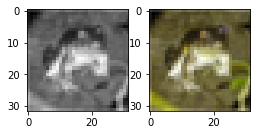

In [28]:
#sanity check
fig1 = plt.figure(figsize=(4,4))
fig1.add_subplot(1,2,1)
plt.imshow(gsc_train[0],cmap='gray', vmin=0, vmax=255)
fig1.add_subplot(1,2,2)
plt.imshow(gt_train[0])

##Model

### U-net class

In [ ]:

class Unet():
#below are modified functions from https://www.tensorflow.org/tutorials/generative/pix2pix
#changes the pix2pix model to a more standard u-net
  def downsample(filters,size,apply_batchnorm=True,lfunc=tf.keras.layers.ReLU()):
    init = tf.random_normal_initializer(0.,0.02)
    res = tf.keras.Sequential() #this submodel will be sequential in nature
    res.add(
    tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=init, use_bias=False))
    res.add(
    tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=init, use_bias=False))
    if (apply_batchnorm):
      res.add(tf.keras.layers.BatchNormalization())
    res.add(lfunc)
    res.add(tf.keras.layers.MaxPool2D())

    return res
  
  def upsample(filters, size, apply_dropout=False,lfunc=tf.keras.layers.ReLU()):
    init = tf.random_normal_initializer(0.,0.02)
    res = tf.keras.Sequential()
    res.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=init,
                                    use_bias=False))
    res.add(
    tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=init, use_bias=False))
    res.add(
    tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=init, use_bias=False))
    res.add(tf.keras.layers.BatchNormalization())
    if (apply_dropout):
      res.add(tf.keras.layers.Dropout(0.5))

    res.add(lfunc)
    #incomplete
    return res
  def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    down_stack = [
      Unet.downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
      Unet.downsample(128, 4),  # (bs, 64, 64, 128)
      Unet.downsample(256, 4),  # (bs, 32, 32, 256)
      Unet.downsample(512, 4),  # (bs, 16, 16, 512)
      Unet.downsample(512, 4),  # (bs, 8, 8, 512)
      Unet.downsample(512, 4),  # (bs, 4, 4, 512)
      Unet.downsample(512, 4),  # (bs, 2, 2, 512)
      Unet.downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
      Unet.upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
      Unet.upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
      Unet.upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
      Unet.upsample(512, 4),  # (bs, 16, 16, 1024)
      Unet.upsample(256, 4),  # (bs, 32, 32, 512)
      Unet.upsample(128, 4),  # (bs, 64, 64, 256)
      Unet.upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

##Train

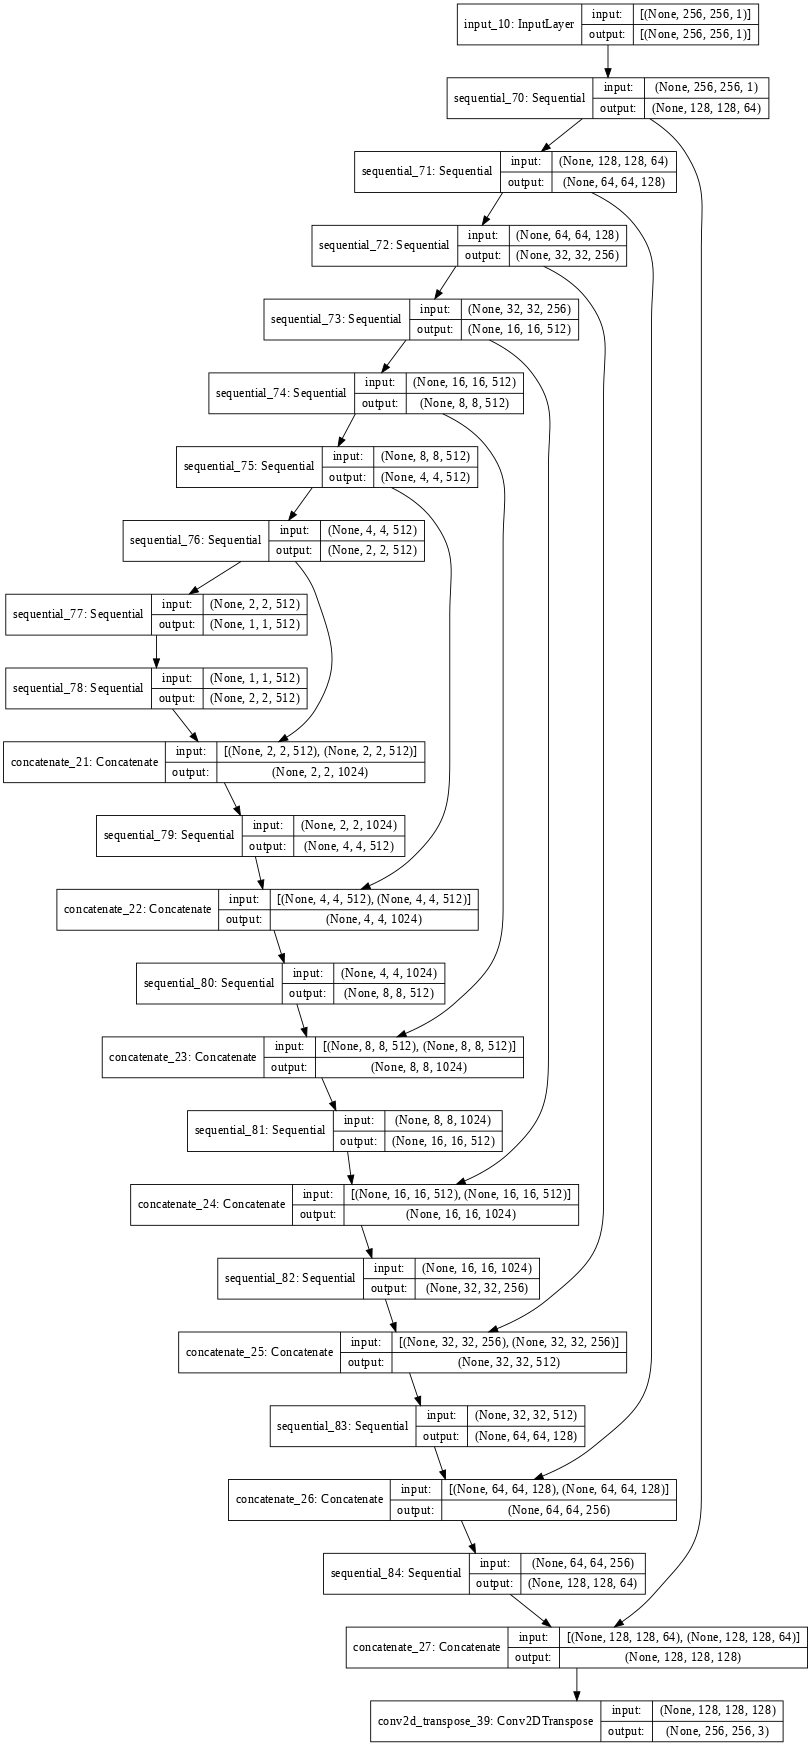

In [ ]:
OUTPUT_CHANNELS = 3
generator = Unet.Generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=64)

# Collab Friend

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 9s 0us/step


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

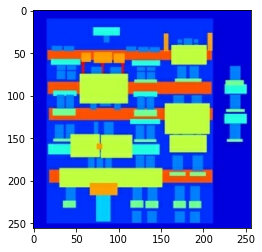

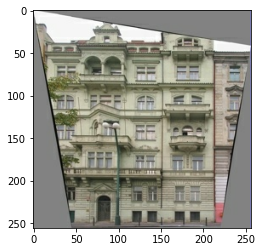

In [ ]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

## uNet

In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

NameError: ignored

## PatchGAN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [ ]:
def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator
    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a discriminator
    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.
        
        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)